# Analysing lines in XP spectra 
## Part I. Hermite functions and representation of XP spectra, using some examples from [Weiler+2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...671A..52W/abstract)


In [1]:
import numpy as np
import scipy
from astropy.table import Table
from matplotlib import pyplot as plt

import math_tools, spectrum_tools, line_analysis

## 1. Hermite functions

Text(0.5, 1.0, 'Hermite functions')

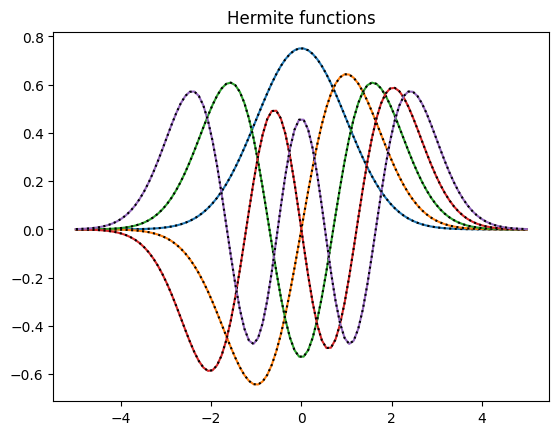

In [2]:
x    = np.linspace(-5,5,100)
test = math_tools.HermiteFunction(x, 55, scipy=False)
# Test if our implementation is correct using the scipy Hermite polynomials
test2= math_tools.HermiteFunction(x, 55, scipy=True)

for ii in np.arange(0,5):
    plt.plot(x, test[:,ii])
    plt.plot(x, test2[:,ii], c="k", ls="dotted")

plt.title("Hermite functions")

## 2. Read the configuration data files

The data are stored in ./ConfigurationData and can be read as follows:

In [3]:
XPConstants = spectrum_tools.XPConstants(dr="dr3", calib="dr3+weiler2023")

## 3. Visualise some of the involved matrices

The transformation matrices for BP and RP:

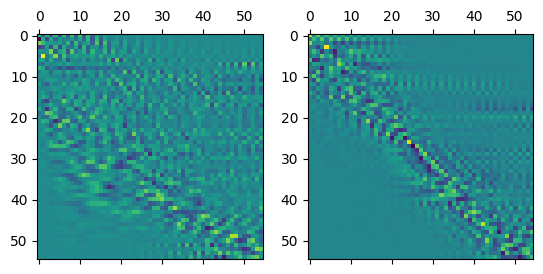

In [4]:
ax0 = plt.subplot(121)
ax0.matshow(XPConstants.TrafoBP)
ax1 = plt.subplot(122)
ax1.matshow(XPConstants.TrafoRP)

The derivative matrices (shown only for the first 10 Hermite functions):

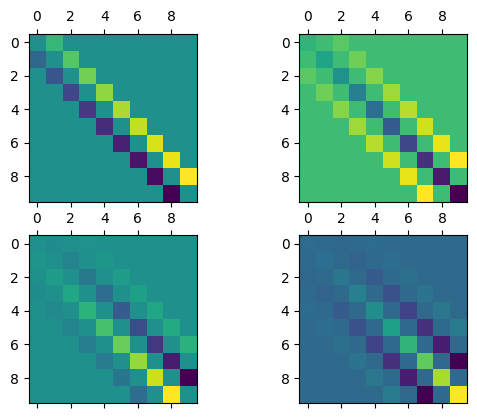

In [5]:
ax0 = plt.subplot(221)
ax0.matshow(XPConstants.D1[:10,:10])
ax1 = plt.subplot(222)
ax1.matshow(XPConstants.D2[:10,:10])
ax2 = plt.subplot(223)
ax2.matshow(XPConstants.D3[:10,:10])
ax3 = plt.subplot(224)
ax3.matshow(XPConstants.D4[:10,:10])

The roots calculation matrix:

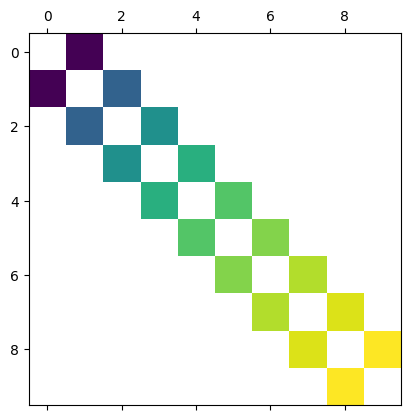

In [6]:
plt.matshow(XPConstants.RootsH[:10,:10], norm="log")

## 4. Get an internally calibrated XP spectrum (flux vs. pseudo-wavelength)

We start by reading some test XP data containing the 4 example Gaia DR3 stars discussed in the Weiler+2023 paper:

In [7]:
t = Table.read("./data/xp_continuous_combined_weiler2023_examples.vot")

source_id: 505171240162594560


<ErrorbarContainer object of 3 artists>

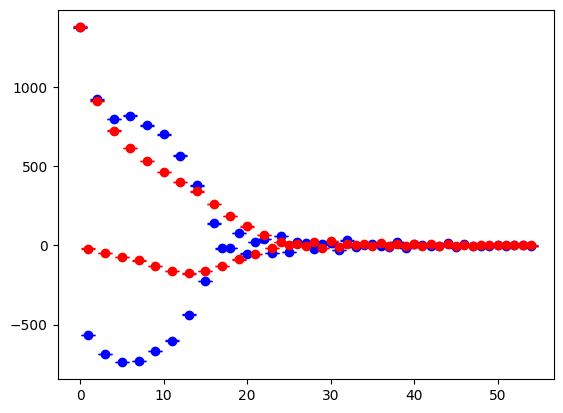

In [8]:
# Select the BP spectrum of one star
i       = 0
XP_spec = spectrum_tools.XP_Spectrum(t[0], rotate_basis=True)
print("source_id:", XP_spec.source_id)

# Plot the transformed XP coefficients (except for the first) 
plt.errorbar(np.arange(0, len(XP_spec.BP)), XP_spec.BP, yerr=XP_spec.BP_err, capsize=5, fmt='o', c="b")
plt.errorbar(np.arange(0, len(XP_spec.RP)), XP_spec.RP, yerr=XP_spec.RP_err, capsize=5, fmt='o', c="r")

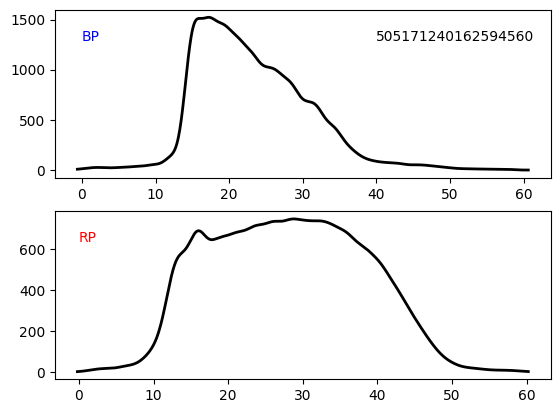

In [9]:
# Plot the spectrum (flux vs. pseudo-wavelength)
ax0  = plt.subplot(211)
x    = np.linspace(-10,10,1000)
l, internal = XP_spec.get_internal_spec(x, instrument="bp")
plt.plot(l, internal, c="k", lw=2)
plt.text(40, 0.85*np.max(internal), XP_spec.source_id)
plt.text(0,  0.85*np.max(internal), "BP", c="b")
ax1 = plt.subplot(212)
l, internal = XP_spec.get_internal_spec(x, instrument="rp")
plt.text(0,  0.85*np.max(internal), "RP", c="r")
plt.plot(l, internal, c="k", lw=2)

In [10]:
# Test if the covariance matrix is correctly transformed by comparing to Michael Weiler's results:
cov_BP = np.genfromtxt("./data/BP_CovarianceMatrix_Hermite.csv", delimiter=',')

print(cov_BP[:4,:4])         # Michael's calculation in R
print(XP_spec.BP_cov[:4,:4]) # python calculation

[[ 2.73354093 -0.25138946 -0.13024555 -0.09016454]
 [-0.25138946  2.56827854 -0.47777632 -0.23346239]
 [-0.13024555 -0.47777632  2.41540615 -0.62067335]
 [-0.09016454 -0.23346239 -0.62067335  2.37876927]]
[[ 2.73354093 -0.25138946 -0.13024555 -0.09016454]
 [-0.25138946  2.56827854 -0.47777632 -0.23346239]
 [-0.13024555 -0.47777632  2.41540615 -0.62067335]
 [-0.09016454 -0.23346239 -0.62067335  2.37876927]]


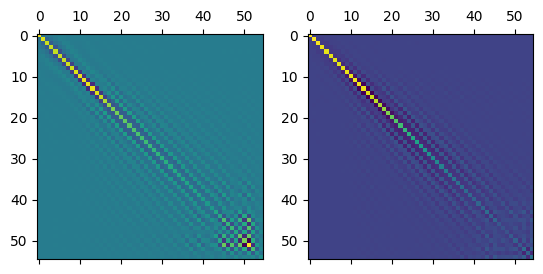

In [11]:
# Display the BP and RP covariance matrices in the transformed basis:
ax0 = plt.subplot(121)
ax0.matshow(XP_spec.BP_cov)
ax1 = plt.subplot(122)
ax1.matshow(XP_spec.RP_cov)

## 5. Get the width of the line spread function (LSF)

In [15]:
import importlib
importlib.reload(spectrum_tools)

<module 'spectrum_tools' from '/home/friedel/Desktop/xp_spectral_lines/spectrum_tools.py'>

In [16]:
u_arr   = np.linspace(5, 55, 15)
lsf_bp  = np.zeros(len(u_arr))
lsf_rp  = np.zeros(len(u_arr))

for ii in range(len(u_arr)):
    XPConstants = spectrum_tools.XPConstants(dr="dr3", calib="dr3+weiler2023")
    lsf_bp[ii]  = spectrum_tools.get_LSF_width(u_arr[ii], setup=XPConstants, 
                                D=1, order=0, instrument="bp")["D"]    
    lsf_rp[ii]  = spectrum_tools.get_LSF_width(u_arr[ii], setup=XPConstants, 
                                D=1, order=0, instrument="rp")["D"]

/home/friedel/Desktop/xp_spectral_lines/line_analysis.py:239: RuntimeWarning: divide by zero encountered in true_divide
  xinf = inf["thirdDerivativeAtRoots"] / inf["ErrorOnThirdDerivativeAtRoots"]
/home/friedel/Desktop/xp_spectral_lines/line_analysis.py:75: RuntimeWarning: divide by zero encountered in true_divide
  J = -np.diag(1/Hermite) @ math_tools.HermiteFunction(realRoots, n=n+1)
/home/friedel/Desktop/xp_spectral_lines/line_analysis.py:75: RuntimeWarning: invalid value encountered in matmul
  J = -np.diag(1/Hermite) @ math_tools.HermiteFunction(realRoots, n=n+1)
/home/friedel/Desktop/xp_spectral_lines/line_analysis.py:234: RuntimeWarning: invalid value encountered in true_divide
  x = e["secondDerivativeAtRoots"] / e["ErrorOnSecondDerivativeAtRoots"]


ValueError: zero-size array to reduction operation maximum which has no identity

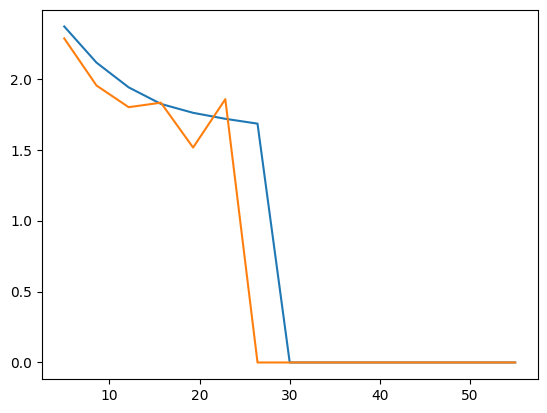

In [17]:
plt.plot(u_arr, lsf_bp)
plt.plot(u_arr, lsf_rp)


In [123]:
weiler2023_tools.HermiteFunction(np.array([1.]), 12).ravel()

array([ 0.45558067,  0.64428837,  0.32214418, -0.26302962, -0.46497508,
       -0.05881521,  0.39050525,  0.26318614, -0.23369114, -0.35829734,
        0.06146344,  0.36783121])

In [ ]:
plt.matshow(XPConstants.LSFBP) 